# Advanced Segmentation: The Watershed Transform

*This tutorial was prepared by Griffin Chure and was generated from a Jupyter notebook. You can download the notebook [here](http://bebi103.caltech.edu/2015/tutorials/r8_watershed_transform.ipynb).*

In [2]:
import warnings

# Our numerical workhorse
import numpy as np

# Image processing tools
import skimage
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.segmentation
import skimage.measure
import skimage.feature
import scipy.ndimage
import skimage.data

#Statistics
import scipy.optimize
import numdifftools as ndt
# Import plotting tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Import file management tools. 
import glob 
import os 
import shutil 

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('white', rc=rc)
sns.set_palette('deep', color_codes=True)
# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Over the past three weeks, we have learned an impressive amount image processing. However, we have only scraped the surface of an enormous field of research.


As has been mentioned repeatedly in class, our eyes are **not** quantitative instruments. When we are interested in extracting quantitative information from images, we are better off turning to our silicon-based overlords to crunch the numbers. However, our eyes are incredibly good at separating objects and identifying and are, in most cases, superior to current computer based techniques. The field is called "computer *vision*" for a reason! Today, we'll learn about a more advanced method of feature/region identification called the watershed transform. 

## What the hell is a watershed?


Remember that an image is simply a two-dimensional matrix in which each entry is a pixel value. The range of this pixel value depends on the bit-depth of the camera, but it is easy to imagine that a typical image is composed of a variety of bright and dark pixels. Unless the image is very noisy, the presence of clusters of high or low pixel values may be used to identify features within the image. Let's take a look at an example image that comes pre-packaged with ``skimage``. 

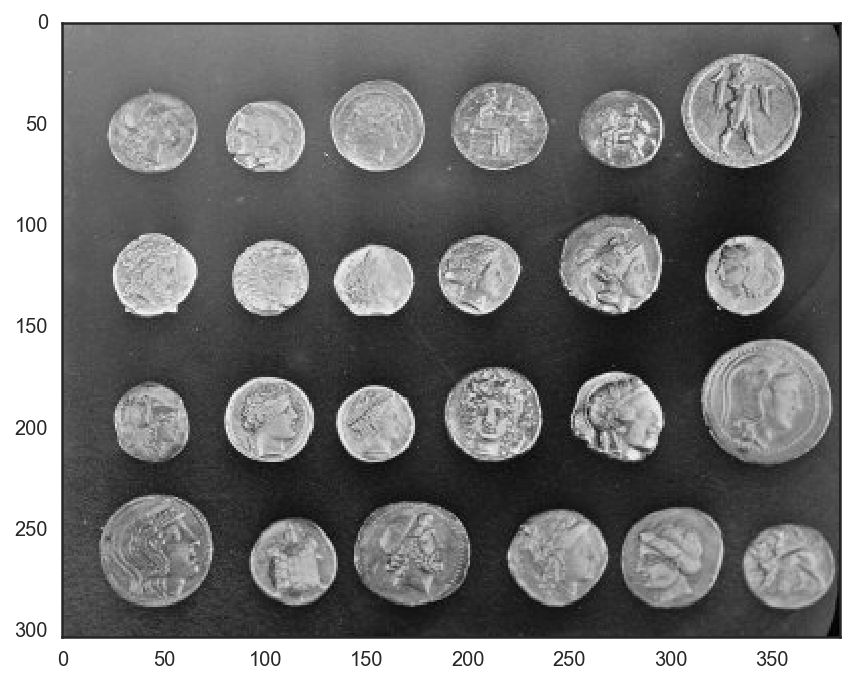

In [3]:
#Load an example image. 
example_im = skimage.img_as_float(skimage.data.coins())

#Plot it. 
plt.imshow(example_im, cmap = plt.cm.gray)

Now let's try to think of this image from a three-dimensional perspective. Suppose that each pixel value in this image serves as the "height" of that point in the two-dimensional array. Our 2-D image is now a three dimensional topological map of the image where regions of high intensity are the "peaks" or "watershed lines" and the low intensity values are the "valleys" or "catchment basins", as can be seen from the following code. 

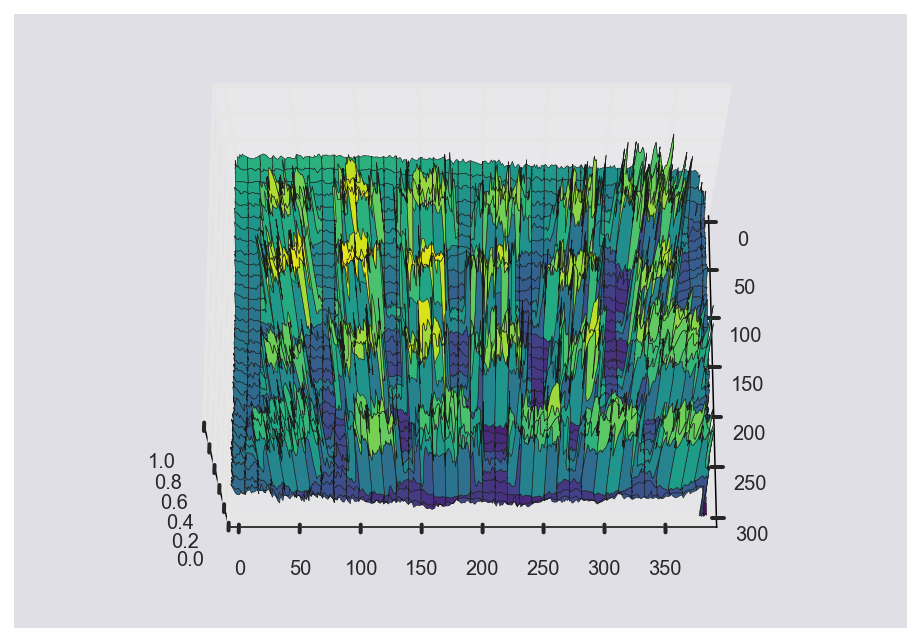

In [5]:
# Get information regarding the shape of the image. 
im_shape = np.shape(example_im)
x = np.arange(0, im_shape[0], 1)
y = np.arange(0, im_shape[1], 1)

# Make a grid 
x, y = np.meshgrid(x, y)

# Do the 3D plot.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(x, y, np.transpose(example_im), cmap=plt.cm.viridis)
plt.xlim([0, im_shape[0]])
plt.ylim([0, im_shape[1]])

# Rotate and tilt the plot so peaks and valleys are obvious
ax.view_init(70, 360)

The watersheds and basins of the image now become more obvious. However, each coin serves as a watershed and (almost) all of the background is the valley. What does this look like if we do some rudimentary edge detection, such as a Sobel filter?

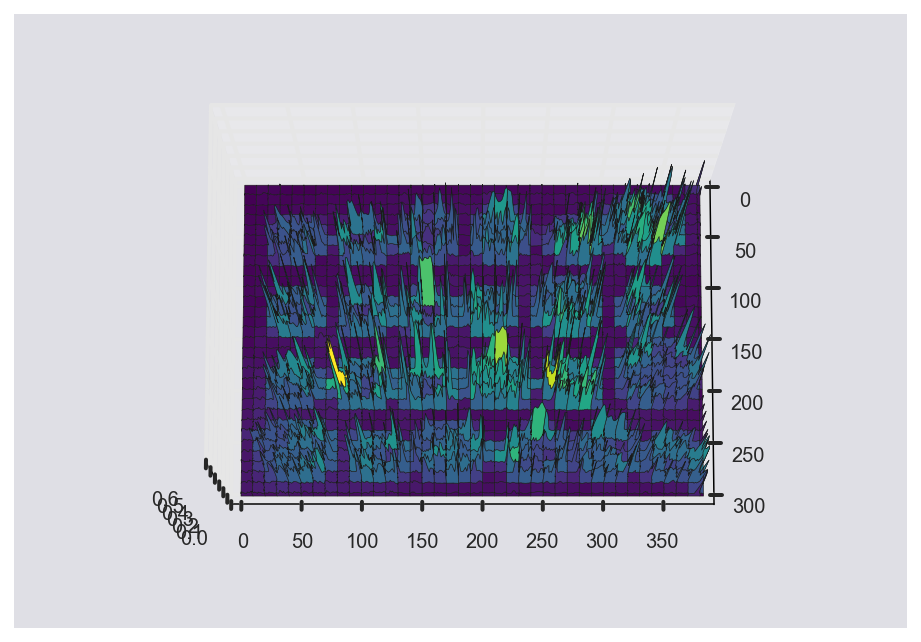

In [6]:
# Compute the gradients of the image using a sobel filter. 
im_grad = skimage.filters.sobel(example_im)

# Get information regarding the shape of the image. 
im_shape = np.shape(im_grad)
x = np.arange(0, im_shape[0], 1)
y = np.arange(0, im_shape[1], 1)

#Make a grid 
x, y = np.meshgrid(x, y)

# Do the 3D plot.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(x, y, np.transpose(im_grad), cmap=plt.cm.viridis)
plt.xlim([0, im_shape[0]])
plt.ylim([0, im_shape[1]])

# Rotate and tilt the plot so peaks and valleys are obvious
ax.view_init(80, 360)

Now, both the face of each coin and the background are valleys while the edges of each coin are the watershed lines. This is where the real power of the watershed transformation reveals itself. Each feature within the image must be a catchment basin surrounded by watersheds, although the watersheds don't all have to be the same height. This is a major advantage watershedding has over simple thresholding for processing complex images. In many cases, watershedding can identify and separate overlapping objects! While there are many flavors of identifying watershed lines (many of which are very well described [here](http://www.cs.rug.nl/~roe/publications/parwshed.pdf)), we will use a flooding algorithm for this tutorial.

#### The Flooding Algorithm

In this tutorial, we will use this approach to identify what is bacterium from background in a complex microcolony as well as individual bacteria from each other.
 
 1. Given an elevation map of some image, place a marker within (or even at the local minimum) of each catchment basin.
 2. Add intensity values (essentially thresholding) to these markers causing flooding of the catchment basin. Each intensity addition will increase the size of the marker, filling the relief of the catchment basin.
 3. Keep adding intensity values until two separate marker pools meet. This indicates that the height of the watershed line has been surpassed and adjacent catchment basins have merged. 
 4. Mark the position of the overflow as the edge of a feature. 
 5. Continue this process until the image is completely flooded and then label the regions. 
 

Let's give the flooding watershed algorithm a spin on my favorite organism -- *E. coli*.

### The data set: measuring exponential growth at single-cell resolution.  

Before we get into the nitty gritty of watershed segmentation, let's look at a biological problem. In homework 8, you were tasked with determining if a single bacterial cell grows exponentially or linearly. Today, we'll watch a single *E. coli* elongate and divide on a hard substrate over the course of 6 hours until a microcolony is formed. By counting the number of cells at each time point, we will be able to determine if population growth is exponential (spoiler -- it is).

Some important points to note.
    
   1. The time between each image is 15 minutes. 
   2. The cells are grown on an agarose pad made of minimal media supplemented with 0.05% glucose.
   3. The images come in both phase and fluorescence. These cells are constitutively expressing YFP from a chromosomal integration.

As we have learned in class, the Marr-Hildreth edge detection method is very effective on fluorescence images. The YFP in these strain was integrated for purposes of segmentation. However, let's pretend that we couldn't use that channel for segmentation. This means that all we have to work with is the phase image. To remind ourselves of the nightmare of phase contrast segmentation, let's load up the data and take a look at the last two images. 

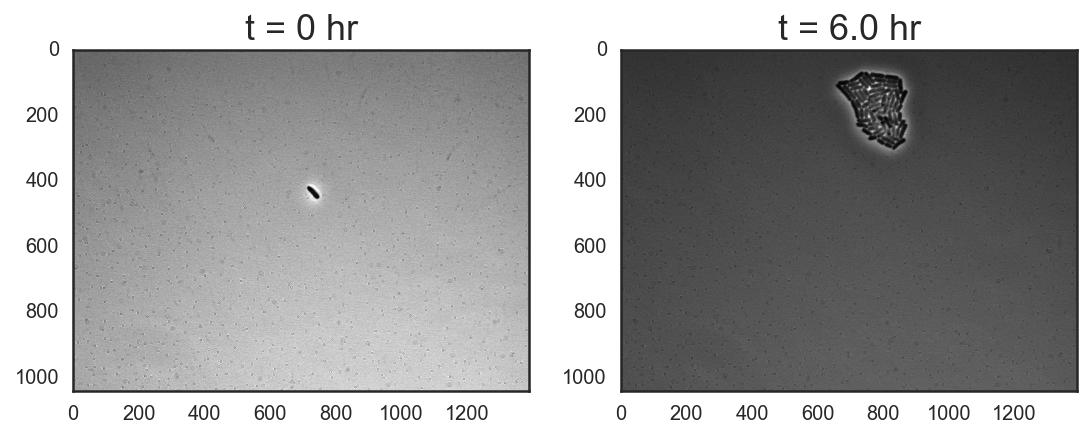

In [7]:
# Define the data directory.
data_dir = '../data/colony_growth/'
phase_im = '*phase.tif'
fitc_im  = '*FITC.tif'

# Glob 'em up. 
phase_glob = glob.glob(data_dir + phase_im)
fitc_glob = glob.glob(data_dir + fitc_im)

# Load up the phase images as an ImageCollection
ic = skimage.io.ImageCollection(phase_glob, conserve_memory=False)
time = np.linspace(0, 24 * 15 / 60)

# Look at the first and last image. 
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(9,5))
ax[0].imshow(ic[0], cmap=plt.cm.gray)
ax[1].imshow(ic[-1], cmap=plt.cm.gray)
    
# Set the titles for each. 
ax[0].set_title('t = 0 hr')
ax[1].set_title('t = %s hr' %time[-1])

We can see that the bacterium found the meaning of life and successfully reproduced! Let's take a closer look at the colony in the last image. 

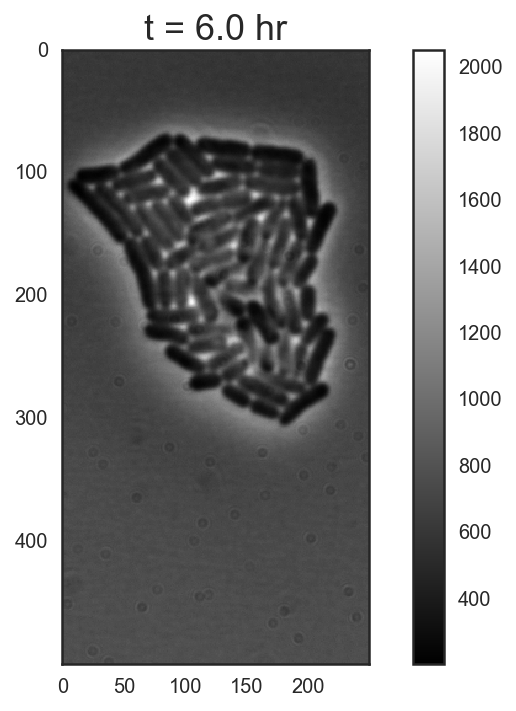

In [8]:
# Plot a cropped version. 
plt.imshow(ic[-1][0:500, 650:900], cmap=plt.cm.gray)
plt.title('t = %s hr' %time[-1])
plt.colorbar()

Now that is an image processing nightmare! As the microcolony grows, cells in the middle of the colony begin to get pushed and stack up on top of each other, generating a three-dimensional colony. This makes matters quite difficult for thresholding. Let's try just thresholding by eye and see how we do.

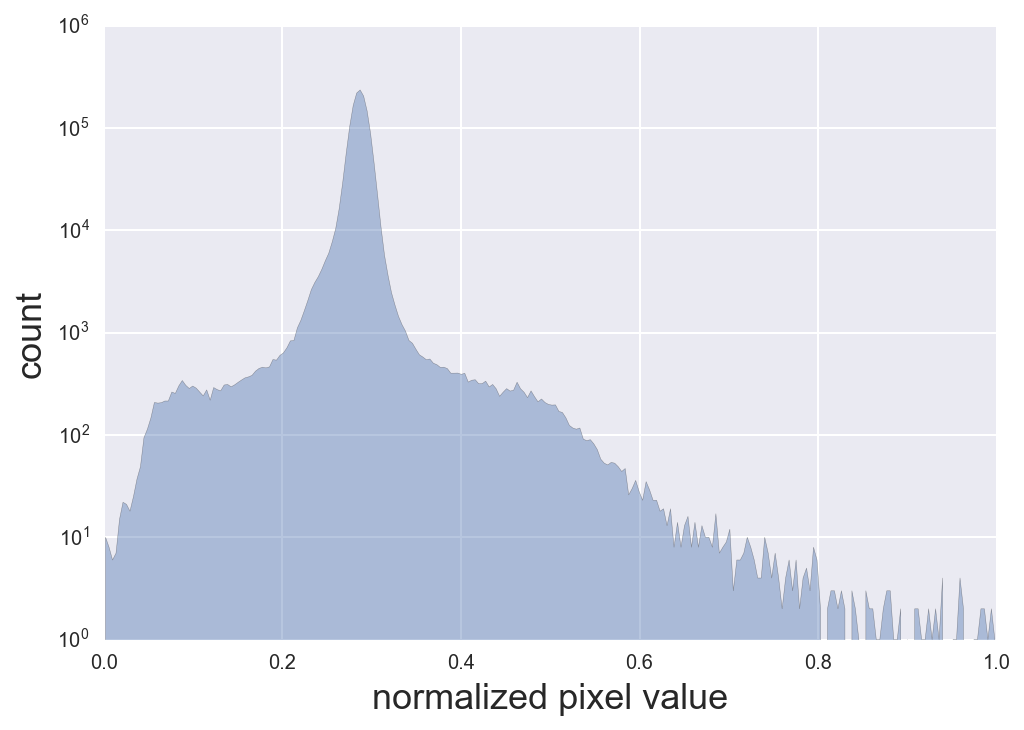

In [9]:
# Blur and do a subtraction. 
im_blur = skimage.filters.gaussian_filter(ic[-1], 20)

# Convert the image to a float. 
im = skimage.img_as_float(ic[-1])
im = im - im_blur
im = (im - im.min()) / (im.max() - im.min())

# Take a look at the image histogram to draw a threshold. 
hist, bins = skimage.exposure.histogram(im)
with sns.axes_style('darkgrid'):
    plt.fill_between(bins, hist, lw=0.25, alpha=0.4)
    plt.yscale('log')
    plt.xlabel('normalized pixel value')
    plt.ylabel('count')

It looks like there is a hump somewhere in the neighborhood of 0.2, which are the cells in this phase image. 

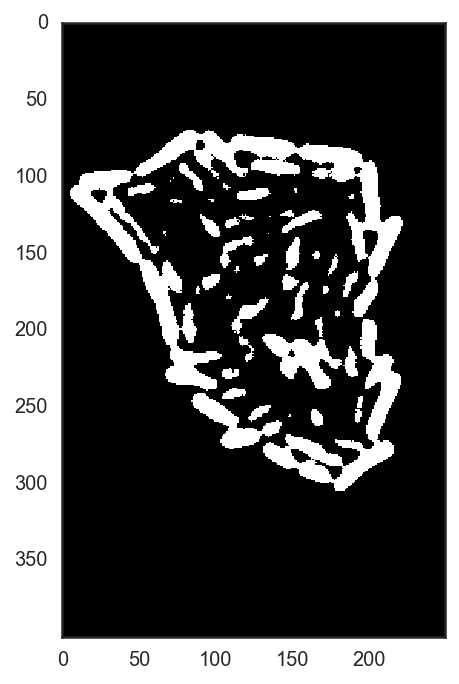

In [11]:
# Set a threshold by eye and apply it to the image. 
thresh = 0.2
im_thresh = im < thresh

# Plot it.
plt.imshow(im_thresh[0:400, 650:900], cmap=plt.cm.gray)

Yikes! We lost nearly the entire center of the colony! Let's see if watershed can help us at all. Let's take a look at the Sobel filtered colony.

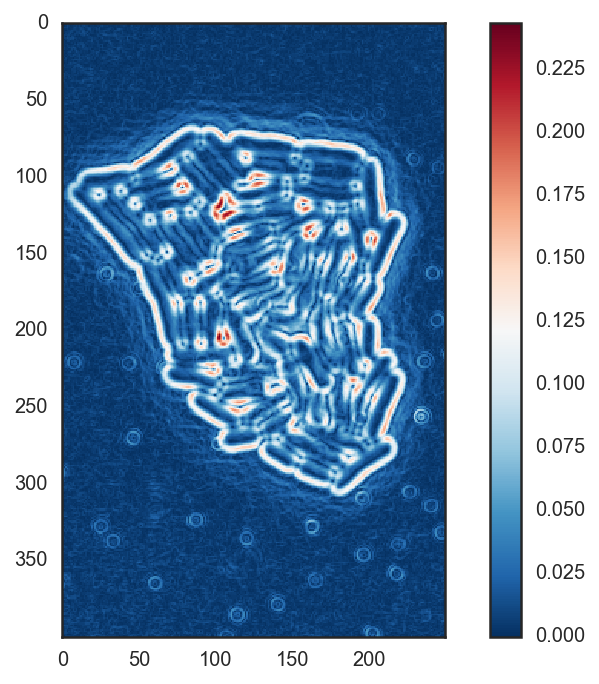

In [13]:
#C ompute the gradient of our image using a Sobel filter.
im_sobel = skimage.filters.sobel(im)

# Let's take a look. 
plt.imshow(im_sobel[0:400, 650:900], cmap=plt.cm.RdBu_r)
plt.colorbar()

There is definitely some weirdness going on here. If we look close at some of the cells, we can see that we actually end up generating catchment basins in between cells as well, which will screw us up when we want to start labeling cells. Before we abandon all hope, let's look more carefully at our phase image. Remember that when imaging bacteria in phase contrast, scattering of the light from the curved edges of the cells results in a bright halo surrounding the cell. Since the bacteria are dark, **the raw phase image is essentially an elevation map**! anything outside neighboring the outside of the cells will be very bright while the cells are dark! We'll do a first round of watershedding using the phase image as our elevation map. To do the flooding, we need to mark some catchment basins. This will be outside of the cells as well as inside the middle of the cells. To generate these markers, we'll resort to some bye-eye thresholding. 

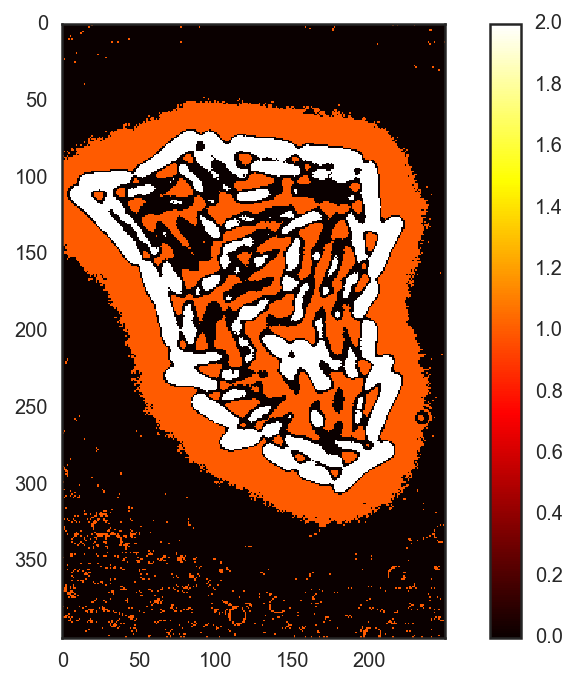

In [14]:
# Set thresholds based on the histogram generated above. 
cells = 0.2
background = 0.3

# Make an image with two labels -- the catchment basins we care about. 
basins = np.zeros_like(im)
basins[im > background] = 1
basins[im < cells] = 2

# Show the basins. 
plt.imshow(basins[0:400, 650:900], cmap=plt.cm.hot)
plt.colorbar()

Now that we have our starting positions, we can do the segmentation.

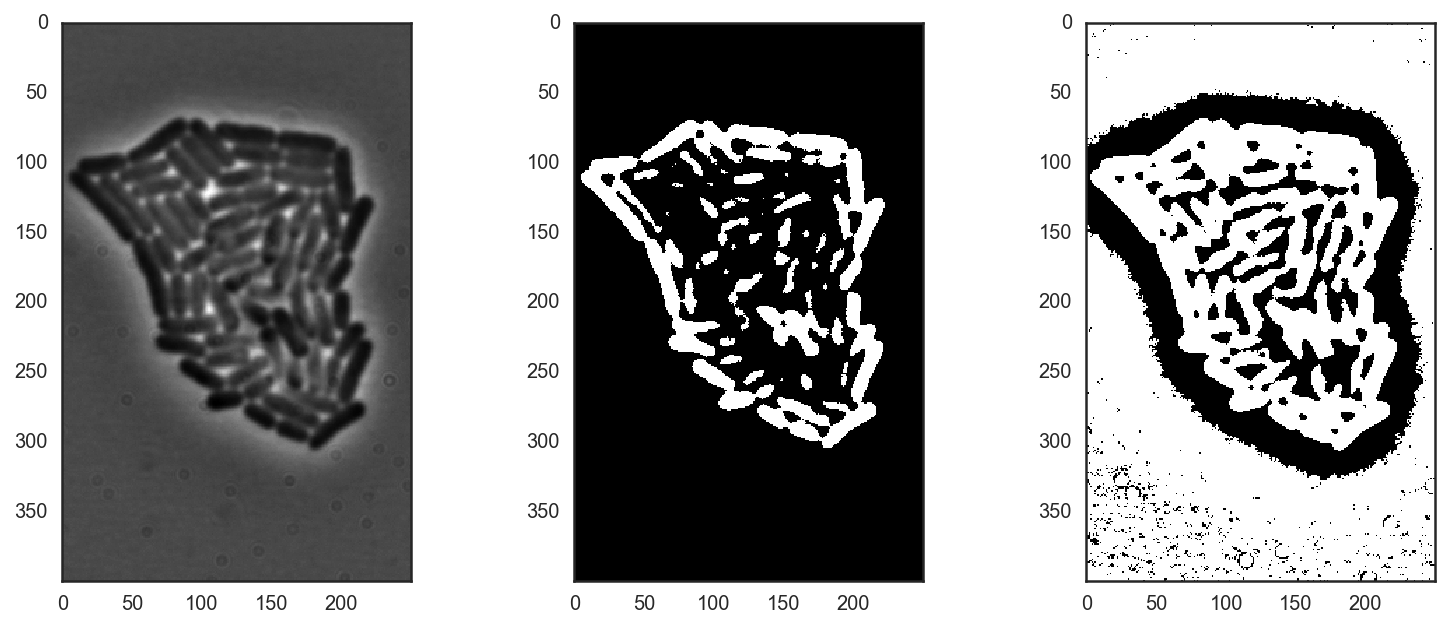

In [15]:
# Do the watershed segmentation
seg = skimage.morphology.watershed(im, basins)
seg = seg > 1

# Show it and our stupid threshold segmentation from before. 
fig, ax = plt.subplots(1,3, figsize=(13,5))
ax[0].imshow(im[0:400, 650:900], cmap = plt.cm.gray)
ax[1].imshow(im_thresh[0:400, 650:900], cmap = plt.cm.gray)
ax[2].imshow(seg[0:400, 650:900], cmap = plt.cm.gray)

Well, that's much better, except we have a huge amount of the background! We can get rid of that by deleting all of the objects that are touching the border of our image. 

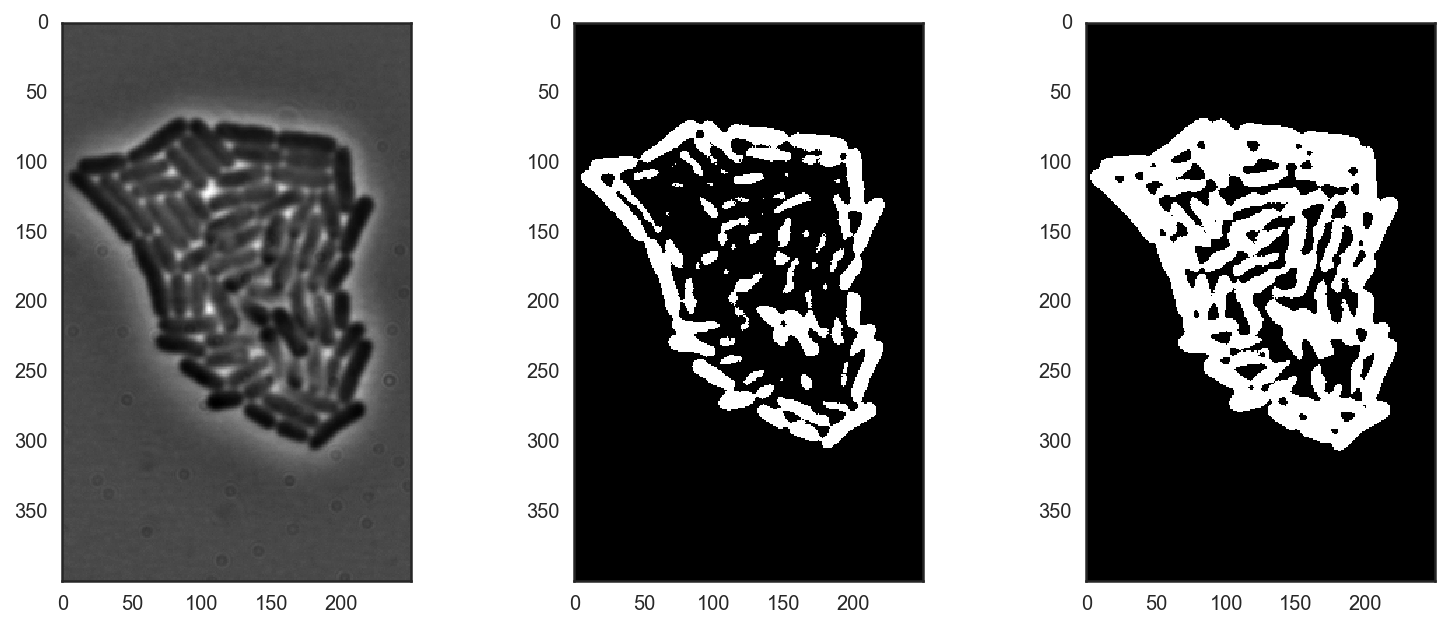

In [16]:
seg = skimage.segmentation.clear_border(seg)
fig, ax = plt.subplots(1,3, figsize=(13,5))
ax[0].imshow(im[0:400, 650:900], cmap = plt.cm.gray)
ax[1].imshow(im_thresh[0:400, 650:900], cmap = plt.cm.gray)
ax[2].imshow(seg[0:400, 650:900], cmap = plt.cm.gray)

We see that there is one small spec of junk left in the background. We can get rid of those with `skimage.morphology.remove_small_objects()`.

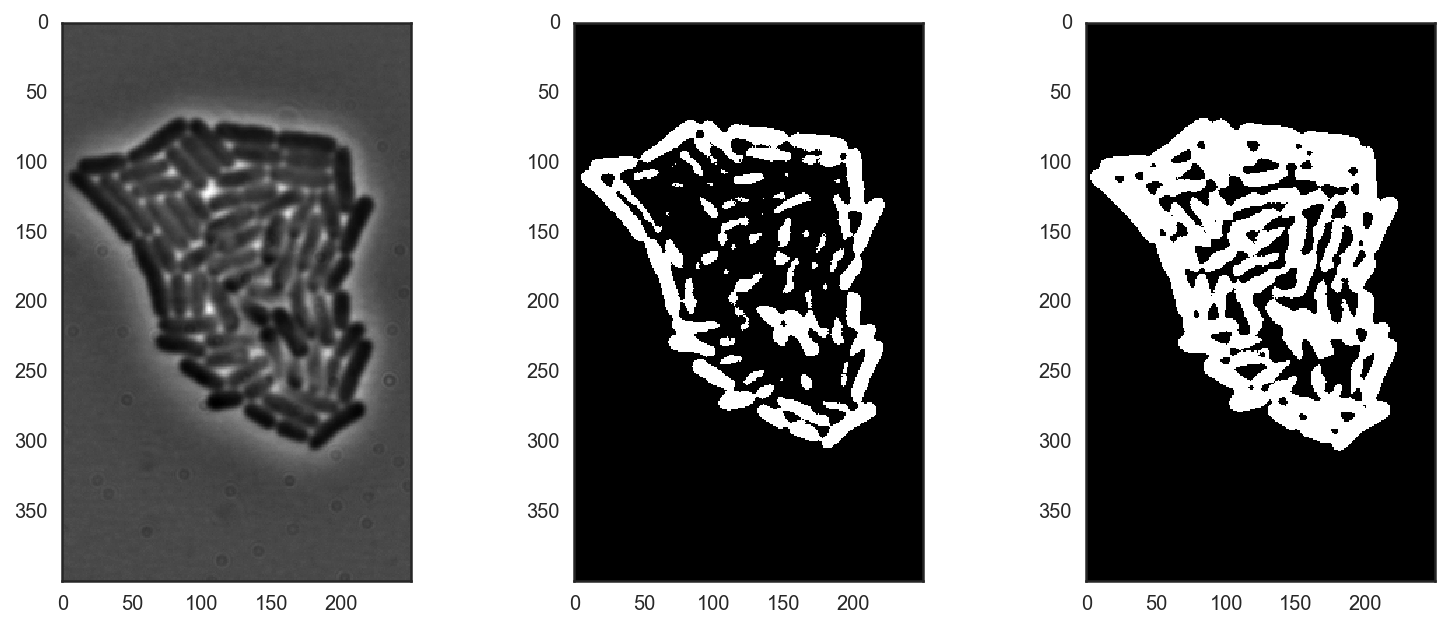

In [17]:
phase_seg = skimage.morphology.remove_small_objects(seg, min_size=100)
with sns.axes_style('white'):
    fig, ax = plt.subplots(1,3, figsize=(13,5))
    ax[0].imshow(im[0:400, 650:900], cmap = plt.cm.gray)
    ax[1].imshow(im_thresh[0:400, 650:900], cmap = plt.cm.gray)
    ax[2].imshow(phase_seg[0:400, 650:900], cmap = plt.cm.gray)

Let's make a stack of our phase image, our thresholding, and our watershed to see how we did! We'll use CMY coloring so cells that were caught in both will be colored white. 

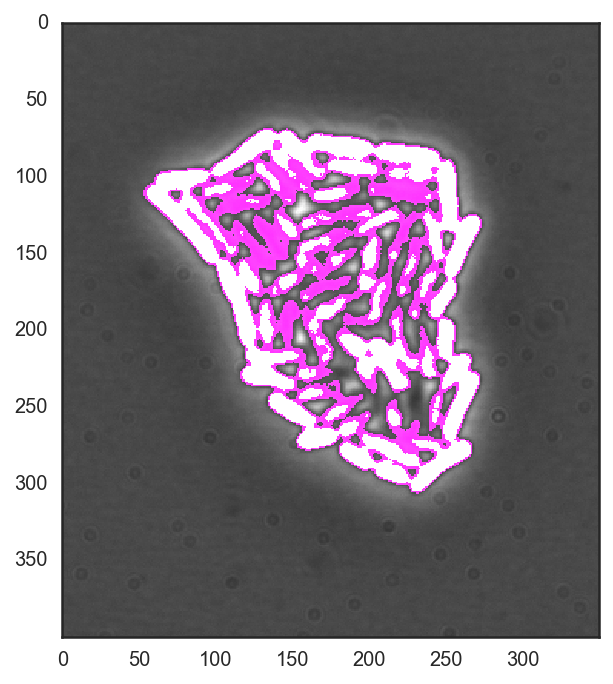

In [18]:
#Copy the phase image and color it wherever our segmentation is true.
thresh_phase = np.copy(im)
wshd_phase = np.copy(im)
thresh_phase[im_thresh] = 1
wshd_phase[phase_seg] = 1

#Make the composite image. 
merge = np.dstack((wshd_phase, thresh_phase, wshd_phase))
plt.imshow(merge[0:400, 600:950])

Well, that's definitely better. All of the cells are still connected, however. This means that we did a pretty good job at separating what is bacterium from background **and** the halo, which is something we would not have been able to do via thresholding alone. To our eye, it is very obvious that there are individual objects in this segmentation. One approach we can now take is to perform a watershed on our binary image using a **distance transformation**. This transformation will assign each pixel in the image a value that corresponds to the minimum distance from that pixel to a boundary. In our binary mask, the center of each bacterium will have the highest value in the distance transformation as it is the furthest from the boundary. We can then invert this distance transform to create a new (and improved) elevation map! 

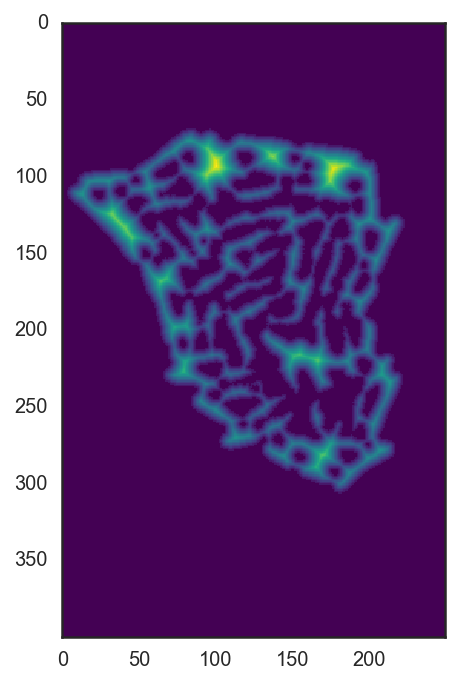

In [19]:
# Compute the distance transform of our above 
distances = scipy.ndimage.distance_transform_edt(phase_seg)
plt.imshow(distances[0:400, 650:900], cmap = plt.cm.viridis)

Now we find the local maximum in each cell.

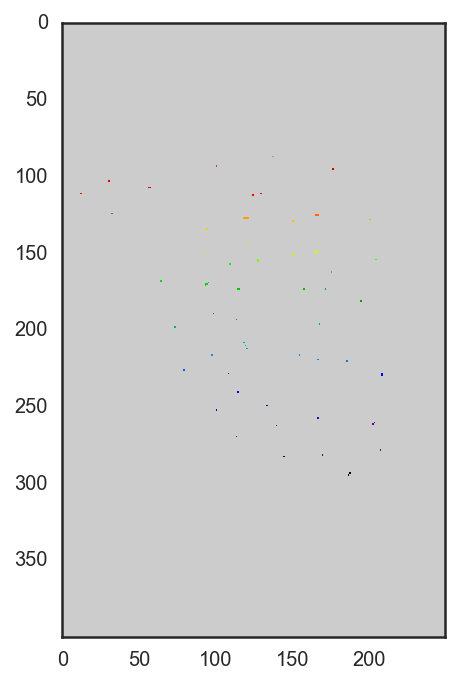

In [20]:
# Find the local maxima. 
local_max = skimage.feature.peak_local_max(distances,  indices=False, footprint=None,
                            labels=phase_seg)
# Label the markers.
maxima = skimage.measure.label(local_max)
plt.imshow(maxima[0:400, 650:900], cmap=plt.cm.spectral_r)

In our distance transform, these maxima indicate pixels in a given region furthest from a feature boundary. In our original phase image, these points correspond to the center of cells. We can therefore treat these points as the catchment basins for our final segmentation.

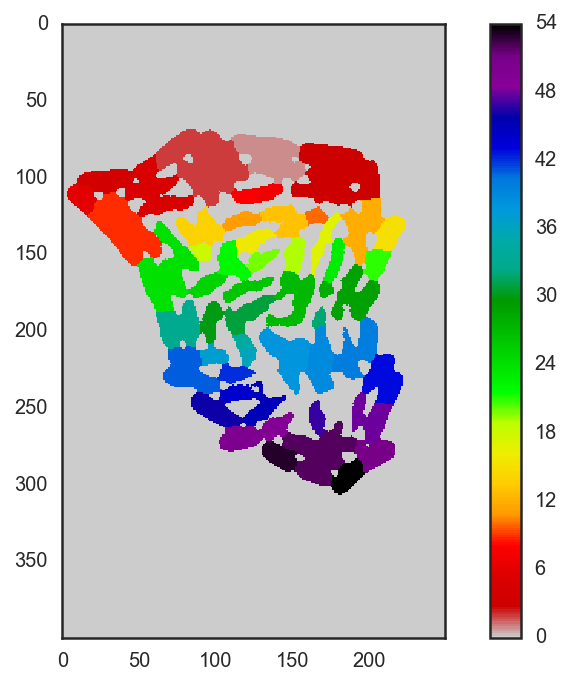

In [21]:
final_seg = skimage.morphology.watershed(-distances, maxima, mask=phase_seg)
plt.imshow(final_seg[0:400, 650:900], cmap=plt.cm.spectral_r)

plt.colorbar()

Okay, so the segmentation isn't perfect. However, it is a hell of a lot better than we could of done via thresholding or even edge detection methods when segmenting in phase. While some cells were clumped together, I would argue that we still did a pretty good job isolating cells. Let's write everything we just did as a function so that we can apply it to each image in the collection and plot our growth curve. 

In [22]:
def phase_segmentation_watershed(im, cell_thresh, bg_thresh):
    """
    Segments a phase contrast image and returns the number of cells
    in each frame. 
    
    Parameters
    ----------
    phase_im : 2D array
        Image to be segmented. 
    
    cell_thresh: float
        Threshold below which cells exist. 
    bg_thresh: float 
        Threshold above which background exists. 
    
    Output
    -------
    num_cells : int
        Returns the number of cells segmented in that frame. 
    """
    
    # Make sure that the phase image is a float. 
    if np.max(im) != 1.0:
        im = (im - im.min()) / (im.max() - im.min())
    
    # Make the image mask. 
    im_mask = im < cell_thresh
    dilation_selem = skimage.morphology.disk(10)
    im_mask_dilation = skimage.morphology.binary_dilation(
                                            im_mask, selem=dilation_selem)
    
    # Generate the catchment basins. 
    basins = np.zeros_like(im)
    basins[im < cell_thresh] = 2
    basins[im > bg_thresh] = 1

    # Peform the watershed by flooding. 
    flood_seg = skimage.morphology.watershed(im , basins)
    flood_seg = flood_seg > 1.0
    
    # Now erode the boundaries and compute the distance transform. 
    selem = skimage.morphology.square(3)
    flood_erode = skimage.morphology.binary_erosion(flood_seg, selem=selem)
    flood_seg = skimage.segmentation.clear_border(flood_seg, buffer_size=10)

    # Compute the distance matrix
    distances = scipy.ndimage.distance_transform_edt(flood_seg)
    
    #Find the maxima
    local_max = skimage.feature.peak_local_max(
        distances, indices=False, footprint=None, labels=flood_seg)
    max_lab = skimage.measure.label(local_max)

    #P erform the topological watershed. 
    final_seg = skimage.morphology.watershed(-distances, max_lab, mask=flood_seg)

    # Remove any stray crap. 
    final_seg = skimage.morphology.remove_small_objects(final_seg, min_size=100)

    # Extract the region properties. 
    props = skimage.measure.regionprops(final_seg)
    
    # Determine the number of cells. 
    num_cells = len(props)

    return num_cells  

Cross your fingers!

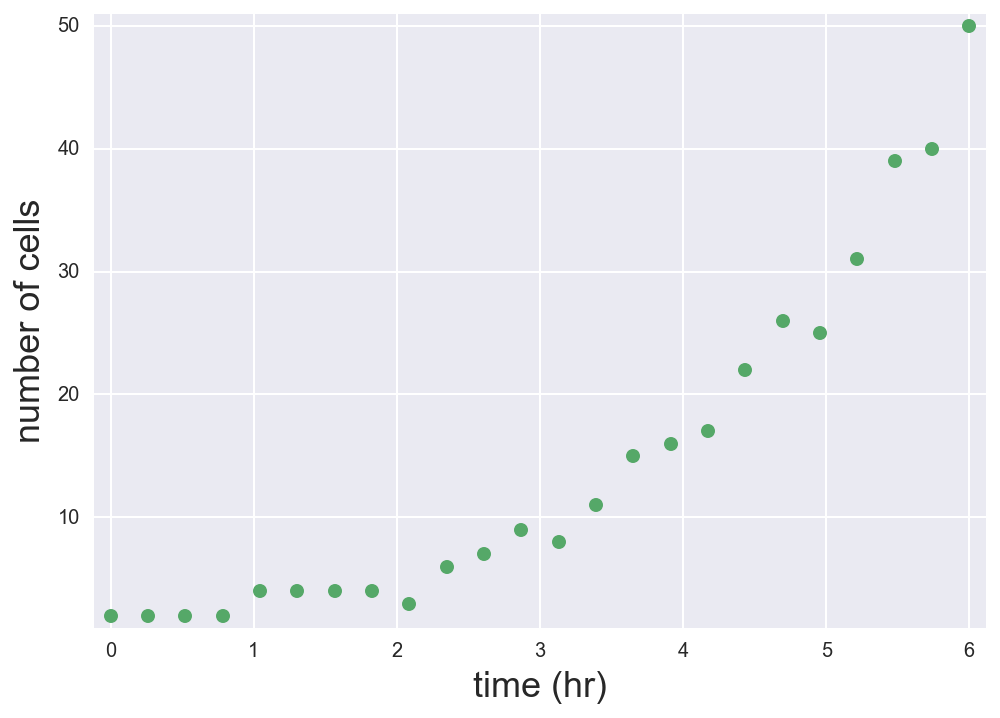

In [23]:
# Make an empty array to add the cell counts. 
wshd_cell_array = np.zeros(len(ic))

for i in range(len(ic)):
    # Load the image. 
    im = ic[i]
    
    # Apply a gaussian blur. 
    im_blur = skimage.filters.gaussian_filter(im, 20.0)
    
    # Make the image a float and subtract the background. 
    im_float = skimage.img_as_float(im)
    im_sub = im_float - im_blur
    im_sub = (im_sub - im_sub.min()) / (im_sub.max() - im_sub.min())
    im_crop = im_sub[0:500, 600:950]

    #Now feed it to our function
    wshd_cell_array[i] = phase_segmentation_watershed(im_crop, 0.2, 0.3)
    
# Now let's plot it!
t = np.linspace(0, 24 * 15 / 60, 24)
with sns.axes_style('darkgrid'):
    plt.plot(t, wshd_cell_array, 'go')
    plt.xlabel('time (hr)')
    plt.ylabel('number of cells')
    plt.margins(0.02)

That certainly passes the eye test for an exponential curve! Now, let's try doing a Laplacian of Gaussian edge detection segmentation procedure on the fluorescence images included in the dataset and see how it compares to our watershed method. 

In [24]:
def log_segmentation(im, selem, thresh=0.001, radius=2.0):
    """
    This function computes the Laplacian of a gaussian filtered image and
    detects object edges as regions which cross zero in the derivative. The
    arguments are as follows:

    im = fluorescence image to be filtered and segmented.
    radius = radius for gaussian filter.
    selem = structural element to be applied for laplacian calculation.
    thresh = threshold to define gradients
    """
     
    # Ensure that the provided image is a float. 
    im_float = (im - im.min()) / (im.max() - im.min())
    
    # Subtract background to fix illumination issues.
    im_gauss = skimage.filters.gaussian_filter(im_float, 20.0)
    im_float = im_float - im_gauss

    # Compute the LoG filter of the image. 
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, radius)

    # Using find_zero_crossings, identify the edges of objects.
    edges = find_zero_crossings(im_LoG, selem, thresh)

    # Skeletonize the edges to a line with a single pixel width.
    skel_im = skimage.morphology.skeletonize(edges)

    # Fill the holes to generate binary image.
    im_fill = scipy.ndimage.morphology.binary_fill_holes(skel_im)

    # Remove small objects and objects touching border. 
    im_large_obj = skimage.morphology.remove_small_objects(im_fill)
    im_final = skimage.segmentation.clear_border(im_large_obj, buffer_size=5)

    # Return the number of cells. 
    im_lab, num_cells= skimage.measure.label(im_final, return_num=True)

    return num_cells


def find_zero_crossings(im, selem, thresh):
    """
    This  function computes the gradients in pixel values of an image after
    applying a sobel filter to a given image. This  function is later used in
    the Laplacian of Gaussian cell segmenter (log_segmentation) function. The
    arguments are as follows.
    
    im = image to be filtered. 
    selem = structural element used to compute gradients. 
    thresh = threshold to define gradients. 
    """

    #apply a maximum and minimum filter to the image. 
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)

    #Compute the gradients using a sobel filter. 
    im_filt = skimage.filters.sobel(im)

    #Find the zero crossings. 
    zero_cross = (((im >=0) & (im_min < 0)) | ((im <= 0) & (im_max > 0)))\
            & (im_filt >= thresh)
    
    return zero_cross

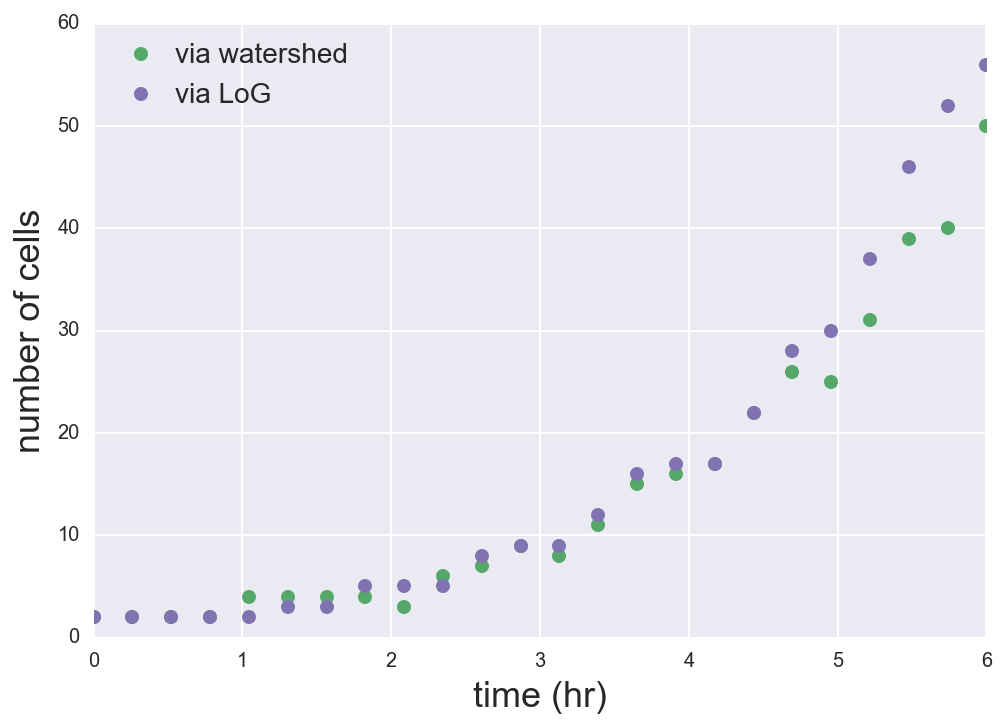

In [25]:
# Do a LoG segmentation of our image. 
ic = skimage.io.ImageCollection(fitc_glob)
selem = skimage.morphology.square(2)
edge_cell_array = np.zeros(len(ic))
for i in range(len(ic)):
    im = ic[i]
    edge_cell_array[i] = log_segmentation(im, selem)

with sns.axes_style('darkgrid'):
    plt.plot(t, wshd_cell_array, 'go', label='via watershed')
    plt.plot(t, edge_cell_array, 'mo', label='via LoG')
    plt.xlabel('time (hr)')
    plt.ylabel('number of cells')
    plt.legend(loc='upper left', fontsize=14)

Let's see how well each method estimates the growth rate. Our model states that cells grow exponentially such that

$$
N(t) = N_0 \mathrm{e}^{kt}
$$

Let's flex our Bayesian biceps and estimate the growth rate, $k$, given our data from the watershed and edge segmentation approaches to this problem. We will assume that the value of $k$ is Gaussian distributed with some error $\sigma$. We can write down our posterior as

$$\ln P(N_t\ |\ k, t, I) = \frac{n}{2}\, \ln\left(\sum_{i=1}^n \left(N_{t_i} - \mathrm{e}^{kt}\right)^2\right)$$

where $n$ is the number of time points in our dataset. We can be maximally uninformative when choosing a prior for $k$. As this is a rather simple model, let's find the MAP for $k$ through simple least-squares regression. We can start by writing down our log posterior and our residual function.

In [26]:
def log_post(k, p):
    """
    Returns the log of the posterior. 
    
    Parameters
    ----------
    k : float
        Growth constant
    """
    t, n_t = p
    return -len(n_t) / 2 * np.log(np.sum(n_t - np.exp(k * t))**2)


def resid(k, p):
    t, n_t = p
    return n_t - np.exp(k * t)

Now all we have to do is feed our `scipy.optimize.leastsq` with our residual function, initial guess for the growth constant, and our data. 


Most Probable Values for k (≈ 68% of total probability)
-------------------------------------------------------
via watershed = 0.7 ± 0.2 hr^-1
via LoG       = 0.7 ± 0.2 hr^-1





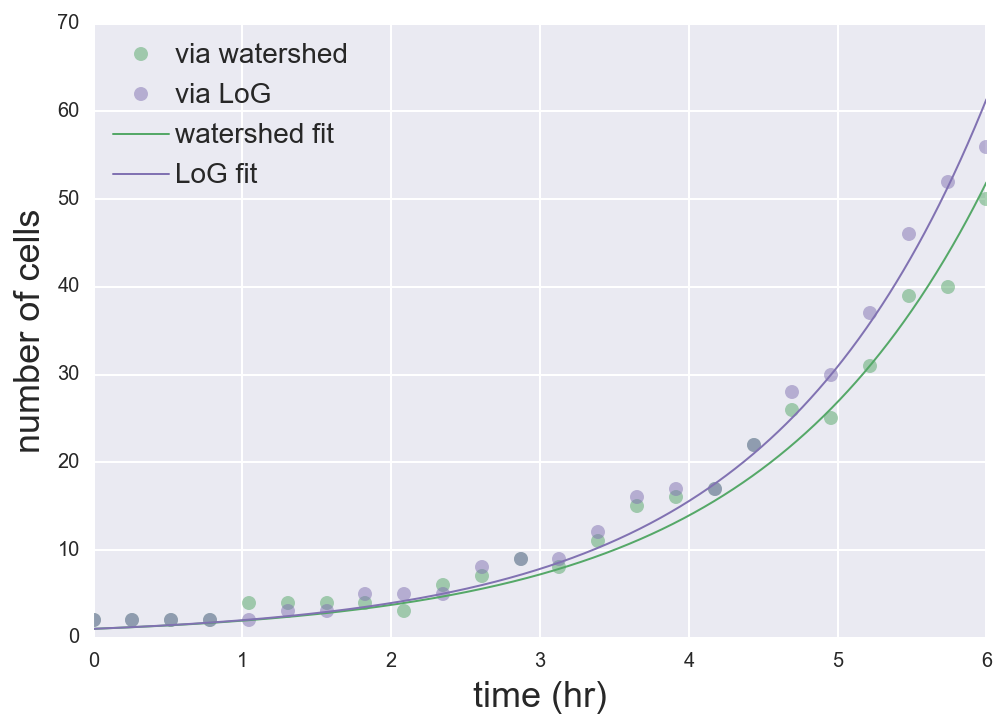

In [27]:
# Generate an initial guess for the growth rate. 
p0 = 1.0

# Define the arguments to feed our minimization function. 
args_wshd = [t, wshd_cell_array]
args_edge = [t, edge_cell_array]

# Minimize it!
wshd_popt, _ = scipy.optimize.leastsq(resid, p0, args_wshd)
edge_popt, _ = scipy.optimize.leastsq(resid, p0, args_edge)

# Now we can extract the optimized values.
k_wshd = wshd_popt[0]
k_edge = edge_popt[0]

# Instantiate the hessian. 
hes_fun = ndt.Hessian(log_post)
hes_wshd = hes_fun(k_wshd, (t, wshd_cell_array))
hes_edge = hes_fun(k_edge, (t, edge_cell_array))
cov_wshd = -np.linalg.inv(hes_wshd)
cov_edge = -np.linalg.inv(hes_edge)

# Now let's print out our most probable values and our uncertainty. 
print("""
Most Probable Values for k (≈ 68% of total probability)
-------------------------------------------------------
via watershed = {0:0.1f} ± {1:0.1f} hr^-1
via LoG       = {2:0.1f} ± {3:0.1f} hr^-1


""".format(k_wshd , np.sqrt(cov_wshd[0,0]), k_edge, np.sqrt(cov_edge[0,0])))

# And now plot everything for posterity!
time = np.linspace(0, 6, 1000)
wshd_fit = np.exp(k_wshd * time)
edge_fit = np.exp(k_edge * time)

with sns.axes_style('darkgrid'):
    plt.plot(t, wshd_cell_array, 'go', label='via watershed', alpha=0.5)
    plt.plot(t, edge_cell_array, 'mo', label='via LoG', alpha=0.5)
    plt.plot(time, wshd_fit, 'g-', lw=1, label='watershed fit')
    plt.plot(time, edge_fit, 'm-', lw=1, label='LoG fit')
    plt.xlabel('time (hr)')
    plt.ylabel('number of cells')
    plt.legend(loc='upper left', fontsize=14)

Wow! The two methods actually agree very nicely, and the MAP for the growth rates are within physical reasoning! So what is the moral of the story? When possible, segment in fluorescence. However, if life (or a previous graduate student) gives you phase, not all hope is lost. 